## Deep Learning Approach

In previous notebook file, we have done some machine learning modelling. Here we will apply some deep learning technique. 
Till now we have our best model as Light GBM with Tfidf text encoding. Lets see whether the deep learning techniques give us lower score than light gbm or not


In [1]:
import pickle
import pandas as pd
import numpy as np
import tensorflow as tf
import keras

In [2]:
with open('X_train_final.pickle','rb') as f:
    X_train = pickle.load(f)
f.close() 
    
with open('X_test_final.pickle','rb') as f:
    X_test = pickle.load(f)
f.close()
    
with open('y_train.pickle','rb') as f:
    y_train = pickle.load(f)
f.close()
 
with open('y_test.pickle','rb') as f:
    y_test = pickle.load(f)
f.close()
    

In [3]:
X_train.shape, X_test.shape

((726439, 11), (311332, 11))

In [4]:
X_train.head()

,name,item_condition_id,brand_name,shipping,item_description,category_1,category_2,category_3,brand_name_encode,category_2_encode,category_3_encode
309614,nested bean sack hungry caterpillar pjs,3,Caterpillar,1,light grey color 3 6m 10 18lbs lightly weighte...,Kids,Boys_0_24_Mos,Other,1,1,1
1316971,100 perfect message capsule,1,Free_People,1,free shipping people really loving new ingenio...,Handmade,Paper_Goods,Stationery,2,2,2
864374,funko,1,Funko,1,brand new funko denver bronco demarcus ware,Vintage_Collectibles,Toy,Sport,3,3,3
1073064,victoria secret pink yoga pant sz,3,PINK,0,cheetah black waist band size small gently use...,Women,Athletic_Apparel,Pants_Tights_Leggings,4,4,4
1117103,baby sperry,2,Unknown,0,infant girl size 1 pink sperry shoe sorry offe...,Kids,Girls_0_24_Mos,Shoes,5,5,5


In [5]:
X_train_text = X_train[['name','item_description']]
X_test_text = X_test[['name','item_description']]

X_train_nontext = X_train.drop(['name','item_description'],axis=1)
X_test_nontext = X_test.drop(['name','item_description'],axis=1)

In [6]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

### Tokenization and sequencing

In [7]:
## Tokenization, sequencing and padding for the item description
maxlength = 100
tokenizer_item = Tokenizer() # do not use the default filter, as we need '_'
tokenizer_item.fit_on_texts(X_train['item_description'].values)

sequences_train_item = tokenizer_item.texts_to_sequences(X_train['item_description'].values)
sequences_test_item = tokenizer_item.texts_to_sequences(X_test['item_description'].values)

padded_train_item = pad_sequences(sequences_train_item, maxlen= maxlength, padding='pre')
padded_test_item = pad_sequences(sequences_test_item, maxlen= maxlength, padding='pre')

item_vocab_size = len(tokenizer_item.word_index) + 1



## Tokenization and sequence for the name
max_length = 10
tokenizer_name = Tokenizer() # do not use the default filter, as we need '_'
tokenizer_name.fit_on_texts(X_train['name'].values)

sequences_train_name = tokenizer_name.texts_to_sequences(X_train['name'].values)
sequences_test_name = tokenizer_name.texts_to_sequences(X_test['name'].values)

padded_train_name = pad_sequences(sequences_train_name, maxlen= max_length, padding='pre')
padded_test_name = pad_sequences(sequences_test_name, maxlen= max_length, padding='pre')

name_vocab_size = len(tokenizer_name.word_index) + 1



print('Item vocab size: ',item_vocab_size )
print('Name vocab size: ',name_vocab_size )

Item vocab size:  104391
Name vocab size:  67194


### Minmax scaler for brand, cat2 and cat 3


In [8]:
from sklearn.preprocessing import MinMaxScaler
## Brand_normalisation

brand_ms = MinMaxScaler()

brand_ms.fit(X_train.brand_name_encode.values.reshape(-1,1))

brand_train_normal= brand_ms.transform(X_train.brand_name_encode.values.reshape(-1,1))
brand_test_normal= brand_ms.transform(X_test.brand_name_encode.values.reshape(-1,1))

## Cat_2 normalisation

cat2_ms = MinMaxScaler()

cat2_ms.fit(X_train.category_2_encode.values.reshape(-1,1))

cat2_train_normal= cat2_ms.transform(X_train.category_2_encode.values.reshape(-1,1))
cat2_test_normal= cat2_ms.transform(X_test.category_2_encode.values.reshape(-1,1))

## Cat_3 normalisation

cat3_ms = MinMaxScaler()

cat3_ms.fit(X_train.category_2_encode.values.reshape(-1,1))

cat3_train_normal= cat3_ms.transform(X_train.category_3_encode.values.reshape(-1,1))
cat3_test_normal= cat3_ms.transform(X_test.category_3_encode.values.reshape(-1,1))

In [9]:
brand_train_normal[:5]

array([[0.        ],
       [0.00023474],
       [0.00046948],
       [0.00070423],
       [0.00093897]])

In [10]:
with open('brand_name_normal.pickle','wb') as f:
    pickle.dump(brand_ms,f)
    
with open('cat2_normal.pickle','wb') as f:
    pickle.dump(cat2_ms,f)
    
with open('cat3_normal.pickle','wb') as f:
    pickle.dump(cat3_ms,f)

### One hot encoding for cat1

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
# One hot encoding
cat_1_vectorizer = CountVectorizer()
cat_1_vectorizer.fit(X_train['category_1'].values)
cat_1_ft = cat_1_vectorizer.get_feature_names()

cat1_train_one = cat_1_vectorizer.transform(X_train['category_1'])
cat1_test_one = cat_1_vectorizer.transform(X_test['category_1'])

### Adding all the non text data

In [12]:
from scipy import sparse 
from scipy.sparse import hstack

X_train_non_txt = hstack(( X_train['item_condition_id'].values.reshape(-1,1),
                          X_train['shipping'].values.reshape(-1,1), 
                          cat1_train_one, 
                          cat2_train_normal,
                          cat3_train_normal, 
                          brand_train_normal)).tocsr()

X_test_non_txt = hstack(( X_test['item_condition_id'].values.reshape(-1,1),
                          X_test['shipping'].values.reshape(-1,1), 
                          cat1_test_one, 
                          cat2_test_normal,
                          cat3_test_normal , 
                          brand_test_normal)).tocsr()
print(X_train_non_txt.shape, y_train.shape)
print(X_test_non_txt.shape, y_test.shape)

(726439, 15) (726439,)
(311332, 15) (311332,)


So our train data will be:

**[ padded_train_name, padded_train_item, X_train_non_text ]**

and test data will be :

**[ padded_test_name, padded_test_item, X_test_non_text ]**

In [13]:
padded_train_item.shape, padded_train_name.shape

((726439, 100), (726439, 10))

### Calling the Glove pretarined word index

In [15]:
import os
import numpy as np
glove_char_vect = {}
f = open('glove.6B.100d.txt',encoding="utf8") ## dimensions of the vector is 100
for line in f:
    values = line.split()
    char = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    glove_char_vect[char] = coefs
f.close()

print('Found %s word vectors.' % len(glove_char_vect))

Found 400000 word vectors.


### Embedding matrix for Item

In [16]:
embedding_matrix_item = np.zeros((len(tokenizer_item.word_index) + 1, 100)) #size is added with one, as if any word is not present, 0 will be given
for word, i in tokenizer_item.word_index.items():
    embedding_vector = glove_char_vect.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix_item[i] = embedding_vector

In [17]:
embedding_matrix_item.shape

(104391, 100)

### Embedding matrix for Name

In [18]:
embedding_matrix_name = np.zeros((len(tokenizer_name.word_index) + 1, 100)) #size is added with one, as if any word is not present, 0 will be given
for word, i in tokenizer_name.word_index.items():
    embedding_vector = glove_char_vect.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix_name[i] = embedding_vector

In [19]:
embedding_matrix_name.shape

(67194, 100)

In [20]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Lambda
from keras.layers.embeddings import Embedding
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, LSTM
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.merge import Concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

### CNN+LSTM  (Model 1)

name input --> embedding --> Cnn --> maxpool --> Lstm -->dense1

item_input --> embedding --> Cnn --> maxpool --> cnn --> maxpool --> lstm --> dense2

non_text_input --> dense --> dropout --> dense3

concat(dense1 , dense2, dense3) --> dense -->drop --> dense --> drop --> dense(out)


In [24]:
## Define input layer for padded_name, padded_item and non_text features respectively

name_in = Input( shape=(10))

item_in = Input(shape=(100))

non_text_in = Input(shape=(15))


##Defining embedding layer for padded name and padded item respectively

embedding_name = Embedding(len(tokenizer_name.word_index) + 1,
                 100,
                 weights=[embedding_matrix_name],
                 trainable=False) (name_in)


embedding_item = Embedding(len(tokenizer_item.word_index) + 1,
                 100,
                 weights=[embedding_matrix_item],
                 trainable=False) (item_in)



### Defining layers for name

conv1 = Conv1D(32,3, activation='relu', kernel_initializer = keras.initializers.he_normal(seed = 0)) (embedding_name)
pool1 = MaxPooling1D(pool_size=3 , strides=2) (conv1)
lstm1 = LSTM(16, return_sequences=True)(pool1)
dense1 = Flatten()(lstm1)

## Defining layers for item

conv2 = Conv1D(32,3, activation='relu', kernel_initializer = keras.initializers.he_normal(seed = 0)) (embedding_item)
pool2 = MaxPooling1D(pool_size=3 , strides=2) (conv2)
conv3 = Conv1D(32,3, activation='relu', kernel_initializer = keras.initializers.he_normal(seed = 0)) (pool2)
pool3 = MaxPooling1D(pool_size=3 , strides=2) (conv3)
lstm2 = LSTM(16, return_sequences=True)(pool3)
dense2 = Flatten()(lstm2)

## Defining layers for non_text

dense3 = Dense(80,activation = 'relu',kernel_initializer = keras.initializers.he_normal(seed = 0)) (non_text_in)
drop1 = Dropout(0.2)(dense3)
dense4 = Dense(30,activation = 'relu',kernel_initializer = keras.initializers.he_normal(seed = 0)) (drop1)

## Concat all three dense layers

con1 = Concatenate()([dense1,dense2,dense4])

dense5 = Dense(64,activation = 'relu',kernel_initializer = keras.initializers.he_normal(seed = 0)) (con1)
drop2 =  Dropout(0.2)(dense5)
dense6 = Dense(16,activation = 'relu',kernel_initializer = keras.initializers.he_normal(seed = 0)) (drop2)
drop3 = Dropout(0.2)(dense6)
dense7 = Dense(1,activation = 'relu',kernel_initializer = keras.initializers.he_normal(seed = 0)) (drop3)

model = Model(inputs = [name_in, item_in,non_text_in], outputs = dense7)
model.summary()

            





Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 100, 100)     10439100    input_5[0][0]                    
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 98, 32)       9632        embedding_3[0][0]                
____________________________________________________________________________________________

In [26]:
from keras import backend

#Defining custom RMSE metric
def rmse(y_true, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

earlystopper = EarlyStopping(monitor='val_loss', min_delta=0.002,  patience=2, mode='auto', verbose=1, restore_best_weights= True)

reducelr = ReduceLROnPlateau(monitor='val_loss', factor= 0.5, patience=1, verbose= 1, min_delta= 0.002)

model.compile(optimizer= tf.keras.optimizers.Adam(0.0005), loss = 'mean_squared_error', metrics = [rmse])
model.fit([padded_train_name, padded_train_item, X_train_non_txt.toarray()], y_train, epochs = 20,  validation_data=([padded_test_name, padded_test_item, X_test_non_txt.toarray()],y_test), \
           batch_size=300, shuffle=True, callbacks= [earlystopper, reducelr] )


Epoch 1/20
2422/2422 [==============================] - 187s 75ms/step - loss: 1.2613 - rmse: 0.8406 - val_loss: 0.3750 - val_rmse: 0.4675
Epoch 2/20
2422/2422 [==============================] - 194s 80ms/step - loss: 0.5469 - rmse: 0.5728 - val_loss: 0.3513 - val_rmse: 0.4523
Epoch 3/20
2422/2422 [==============================] - 194s 80ms/step - loss: 0.4193 - rmse: 0.4981 - val_loss: 0.3452 - val_rmse: 0.4445
Epoch 4/20
2422/2422 [==============================] - 191s 79ms/step - loss: 0.3621 - rmse: 0.4614 - val_loss: 0.3256 - val_rmse: 0.4355
Epoch 5/20
2422/2422 [==============================] - 188s 78ms/step - loss: 0.3345 - rmse: 0.4427 - val_loss: 0.3201 - val_rmse: 0.4327
Epoch 6/20
2422/2422 [==============================] - 189s 78ms/step - loss: 0.3205 - rmse: 0.4337 - val_loss: 0.3189 - val_rmse: 0.4285

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 7/20
2422/2422 [==============================] - 189s 78ms/step - loss: 0.3121

In [27]:
y_train_predict = model.predict([padded_train_name, padded_train_item, X_train_non_txt.toarray()])
y_test_predict = model.predict([padded_test_name, padded_test_item, X_test_non_txt.toarray()])

In [33]:
model.save('Cnn1d_Lstm.h5')

with open('tokenizer_item.pickle','wb') as f:
    pickle.dump(tokenizer_item,f)
    
with open('tokenizer_name.pickle','wb') as f:
    pickle.dump(tokenizer_name,f)


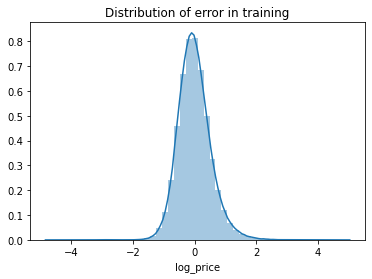

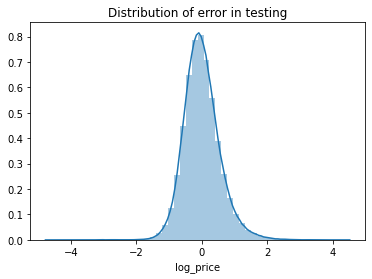

In [60]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns



plt.figure();
sns.distplot(y_train - y_train_predict.reshape(1,-1)[0]);
plt.title('Distribution of error in training');
plt.show()
    
plt.figure();
sns.distplot(y_test - y_test_predict.reshape(1,-1)[0]);
plt.title('Distribution of error in testing');
plt.show()

**Getting Train RMSE score 0.4188 and Test RMSE score 0.4213**

(-0.5, 1385.5, 1511.5, -0.5)

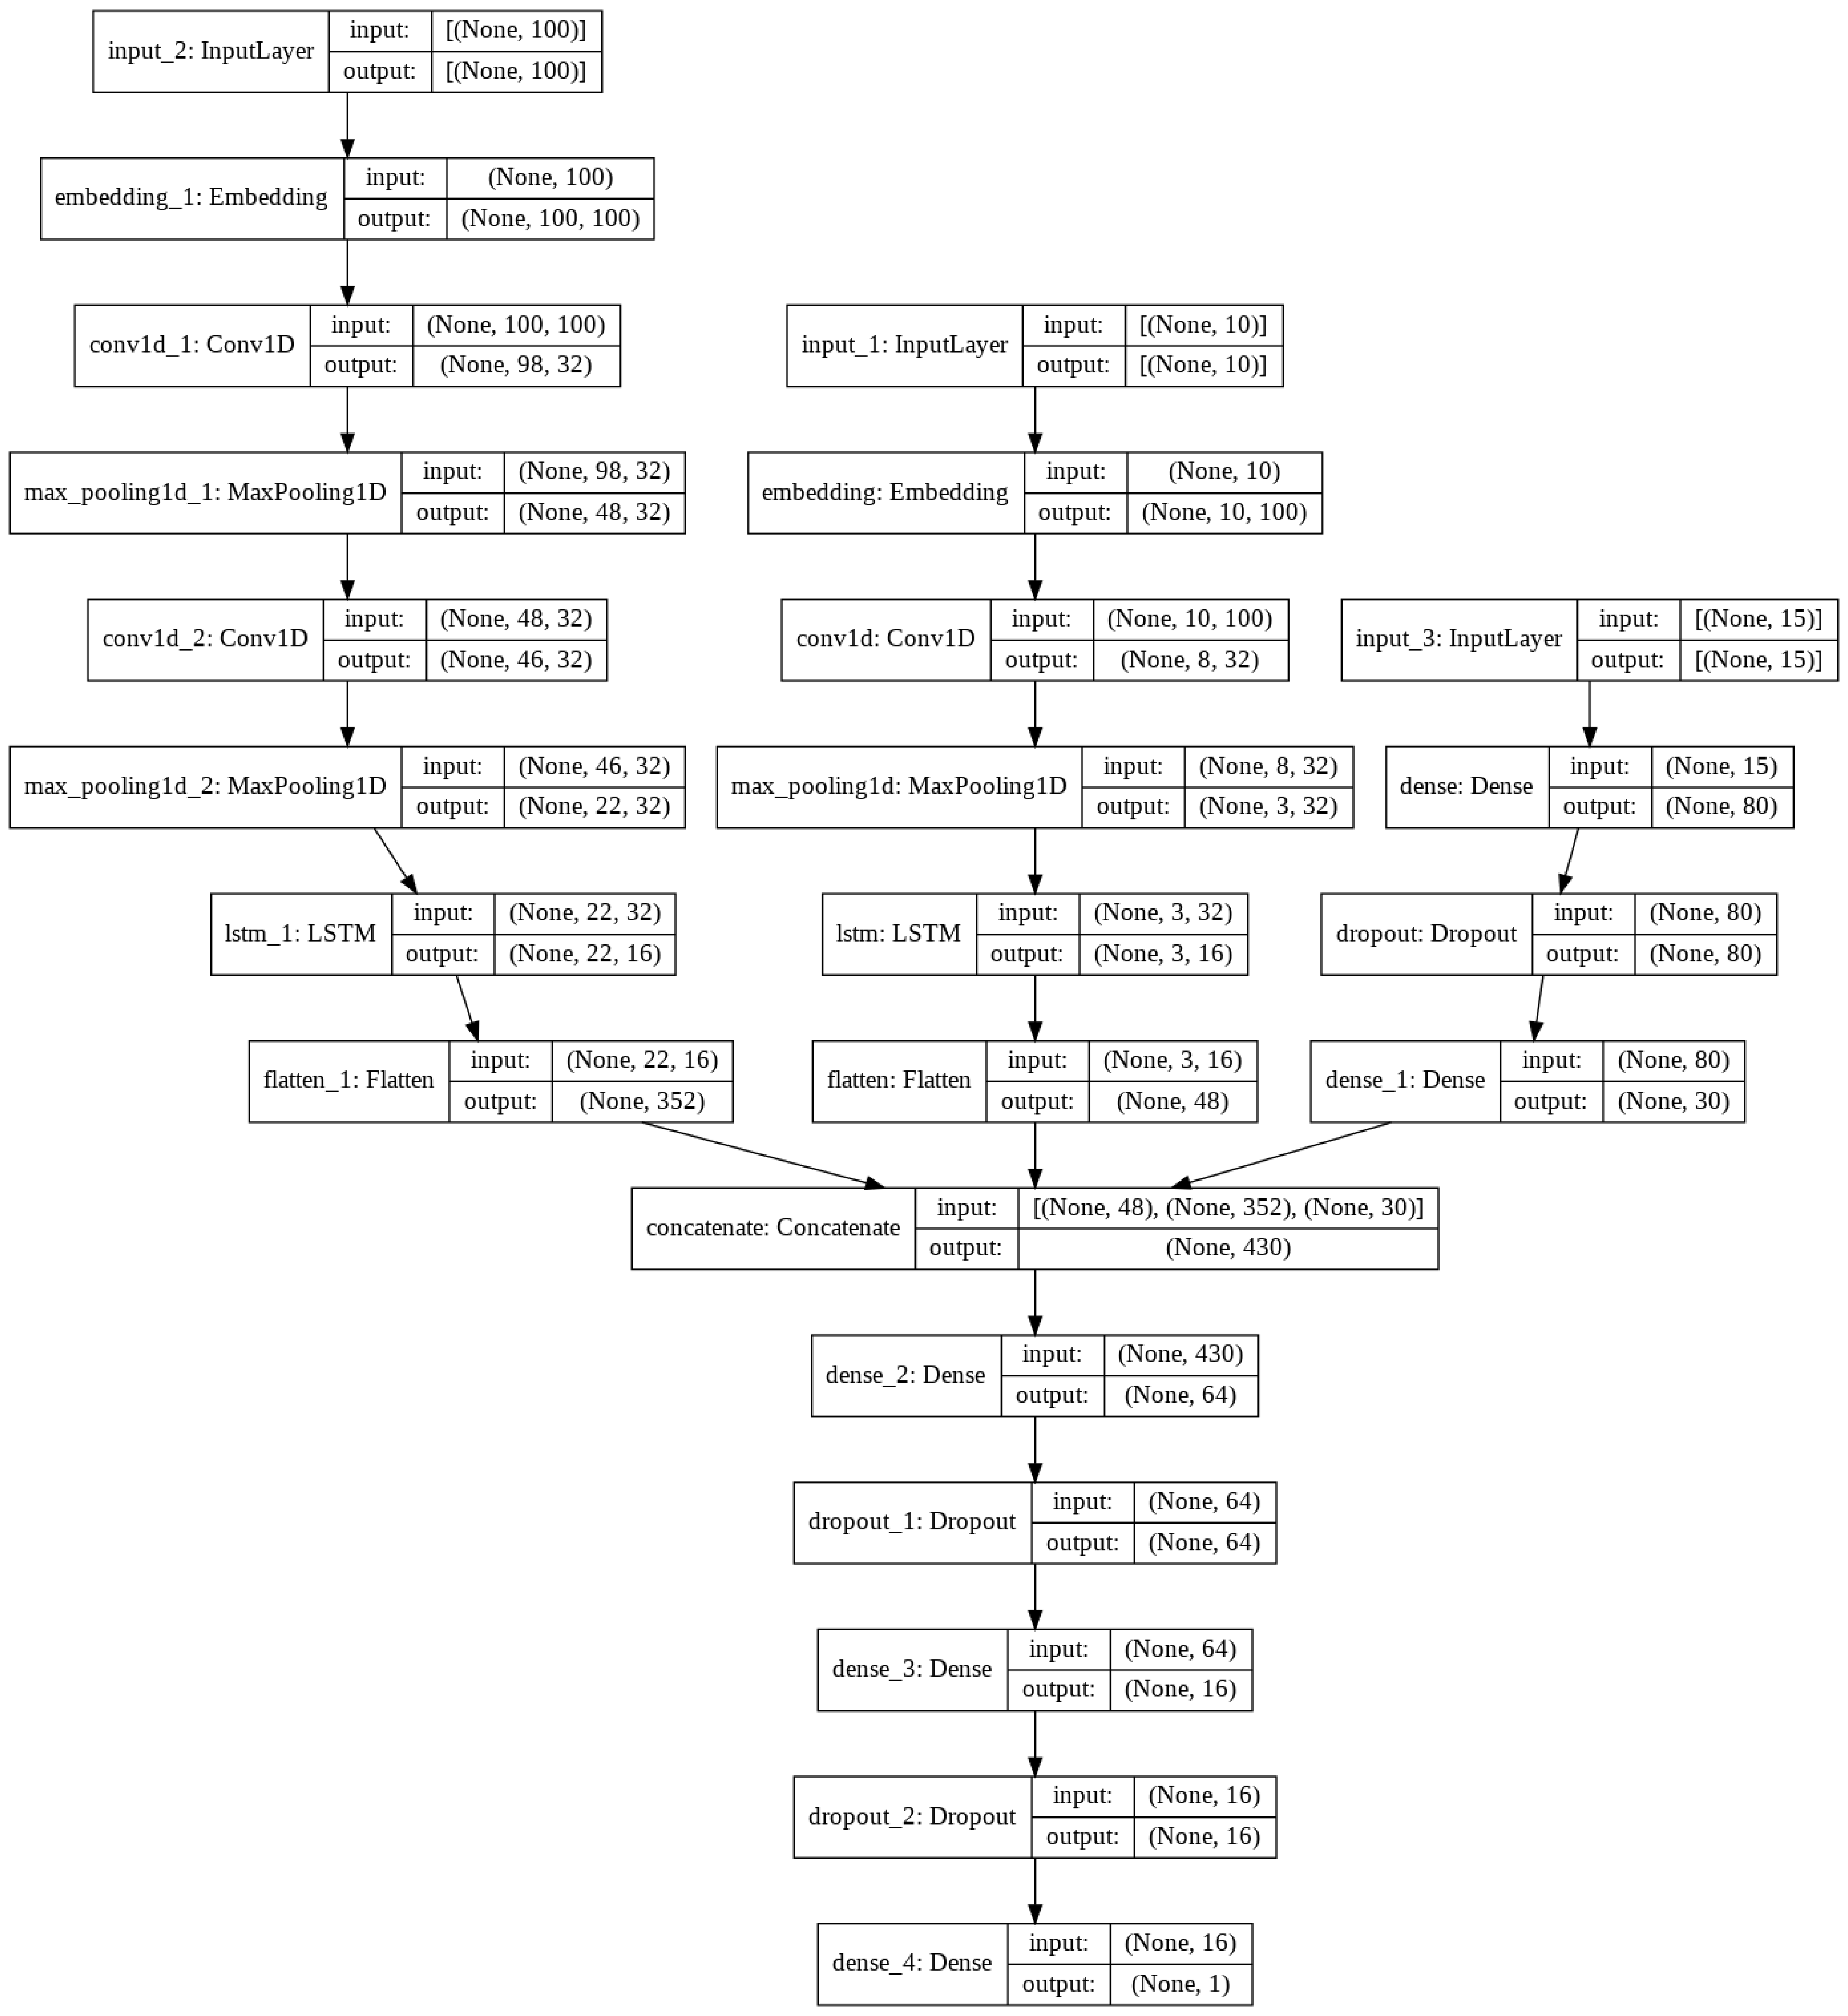

In [72]:
## having some problem with Graphviz, hence plotting the model in google colab and saving it and load it here using matplotlib
import matplotlib.image as img
im = img.imread('Cnn_LSTM_plot.png')
plt.figure(figsize=(80,100));
plt.imshow(im);
plt.axis('off')

### LSTM+ Dense (Model 2)

In [61]:
## Define input layer for padded_name, padded_item and non_text features respectively

name_in = Input( shape=(10))

item_in = Input(shape=(100))

non_text_in = Input(shape=(15))


##Defining embedding layer for padded name and padded item respectively

embedding_name = Embedding(len(tokenizer_name.word_index) + 1,
                 100,
                 weights=[embedding_matrix_name],
                 trainable=False) (name_in)


embedding_item = Embedding(len(tokenizer_item.word_index) + 1,
                 100,
                 weights=[embedding_matrix_item],
                 trainable=False) (item_in)



### Defining layers for name


lstm1 = LSTM(64, return_sequences=True)(embedding_name)
lstm2 = LSTM(32, return_sequences=True)(lstm1)
dense1 = Flatten()(lstm2)

## Defining layers for item


lstm3 = LSTM(64, return_sequences=True)(embedding_item)
lstm4 = LSTM(32, return_sequences=True)(lstm3)
lstm5 = LSTM(16, return_sequences=True)(lstm4)

dense2 = Flatten()(lstm5)

## Defining layers for non_text

dense3 = Dense(80,activation = 'relu',kernel_initializer = keras.initializers.he_normal(seed = 0)) (non_text_in)
drop1 = Dropout(0.2)(dense3)
dense4 = Dense(30,activation = 'relu',kernel_initializer = keras.initializers.he_normal(seed = 0)) (drop1)

## Concat all three dense layers

con1 = Concatenate()([dense1,dense2,dense4])

dense5 = Dense(64,activation = 'relu',kernel_initializer = keras.initializers.he_normal(seed = 0)) (con1)
drop2 =  Dropout(0.2)(dense5)
dense6 = Dense(16,activation = 'relu',kernel_initializer = keras.initializers.he_normal(seed = 0)) (drop2)
drop3 = Dropout(0.2)(dense6)
dense7 = Dense(1,activation = 'relu',kernel_initializer = keras.initializers.he_normal(seed = 0)) (drop3)

model1 = Model(inputs = [name_in, item_in,non_text_in], outputs = dense7)
model1.summary()

            





Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 100, 100)     10439100    input_8[0][0]                    
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 10, 100)      6719400     input_7[0][0]                    
____________________________________________________________________________________________

(-0.5, 1291.5, 1290.5, -0.5)

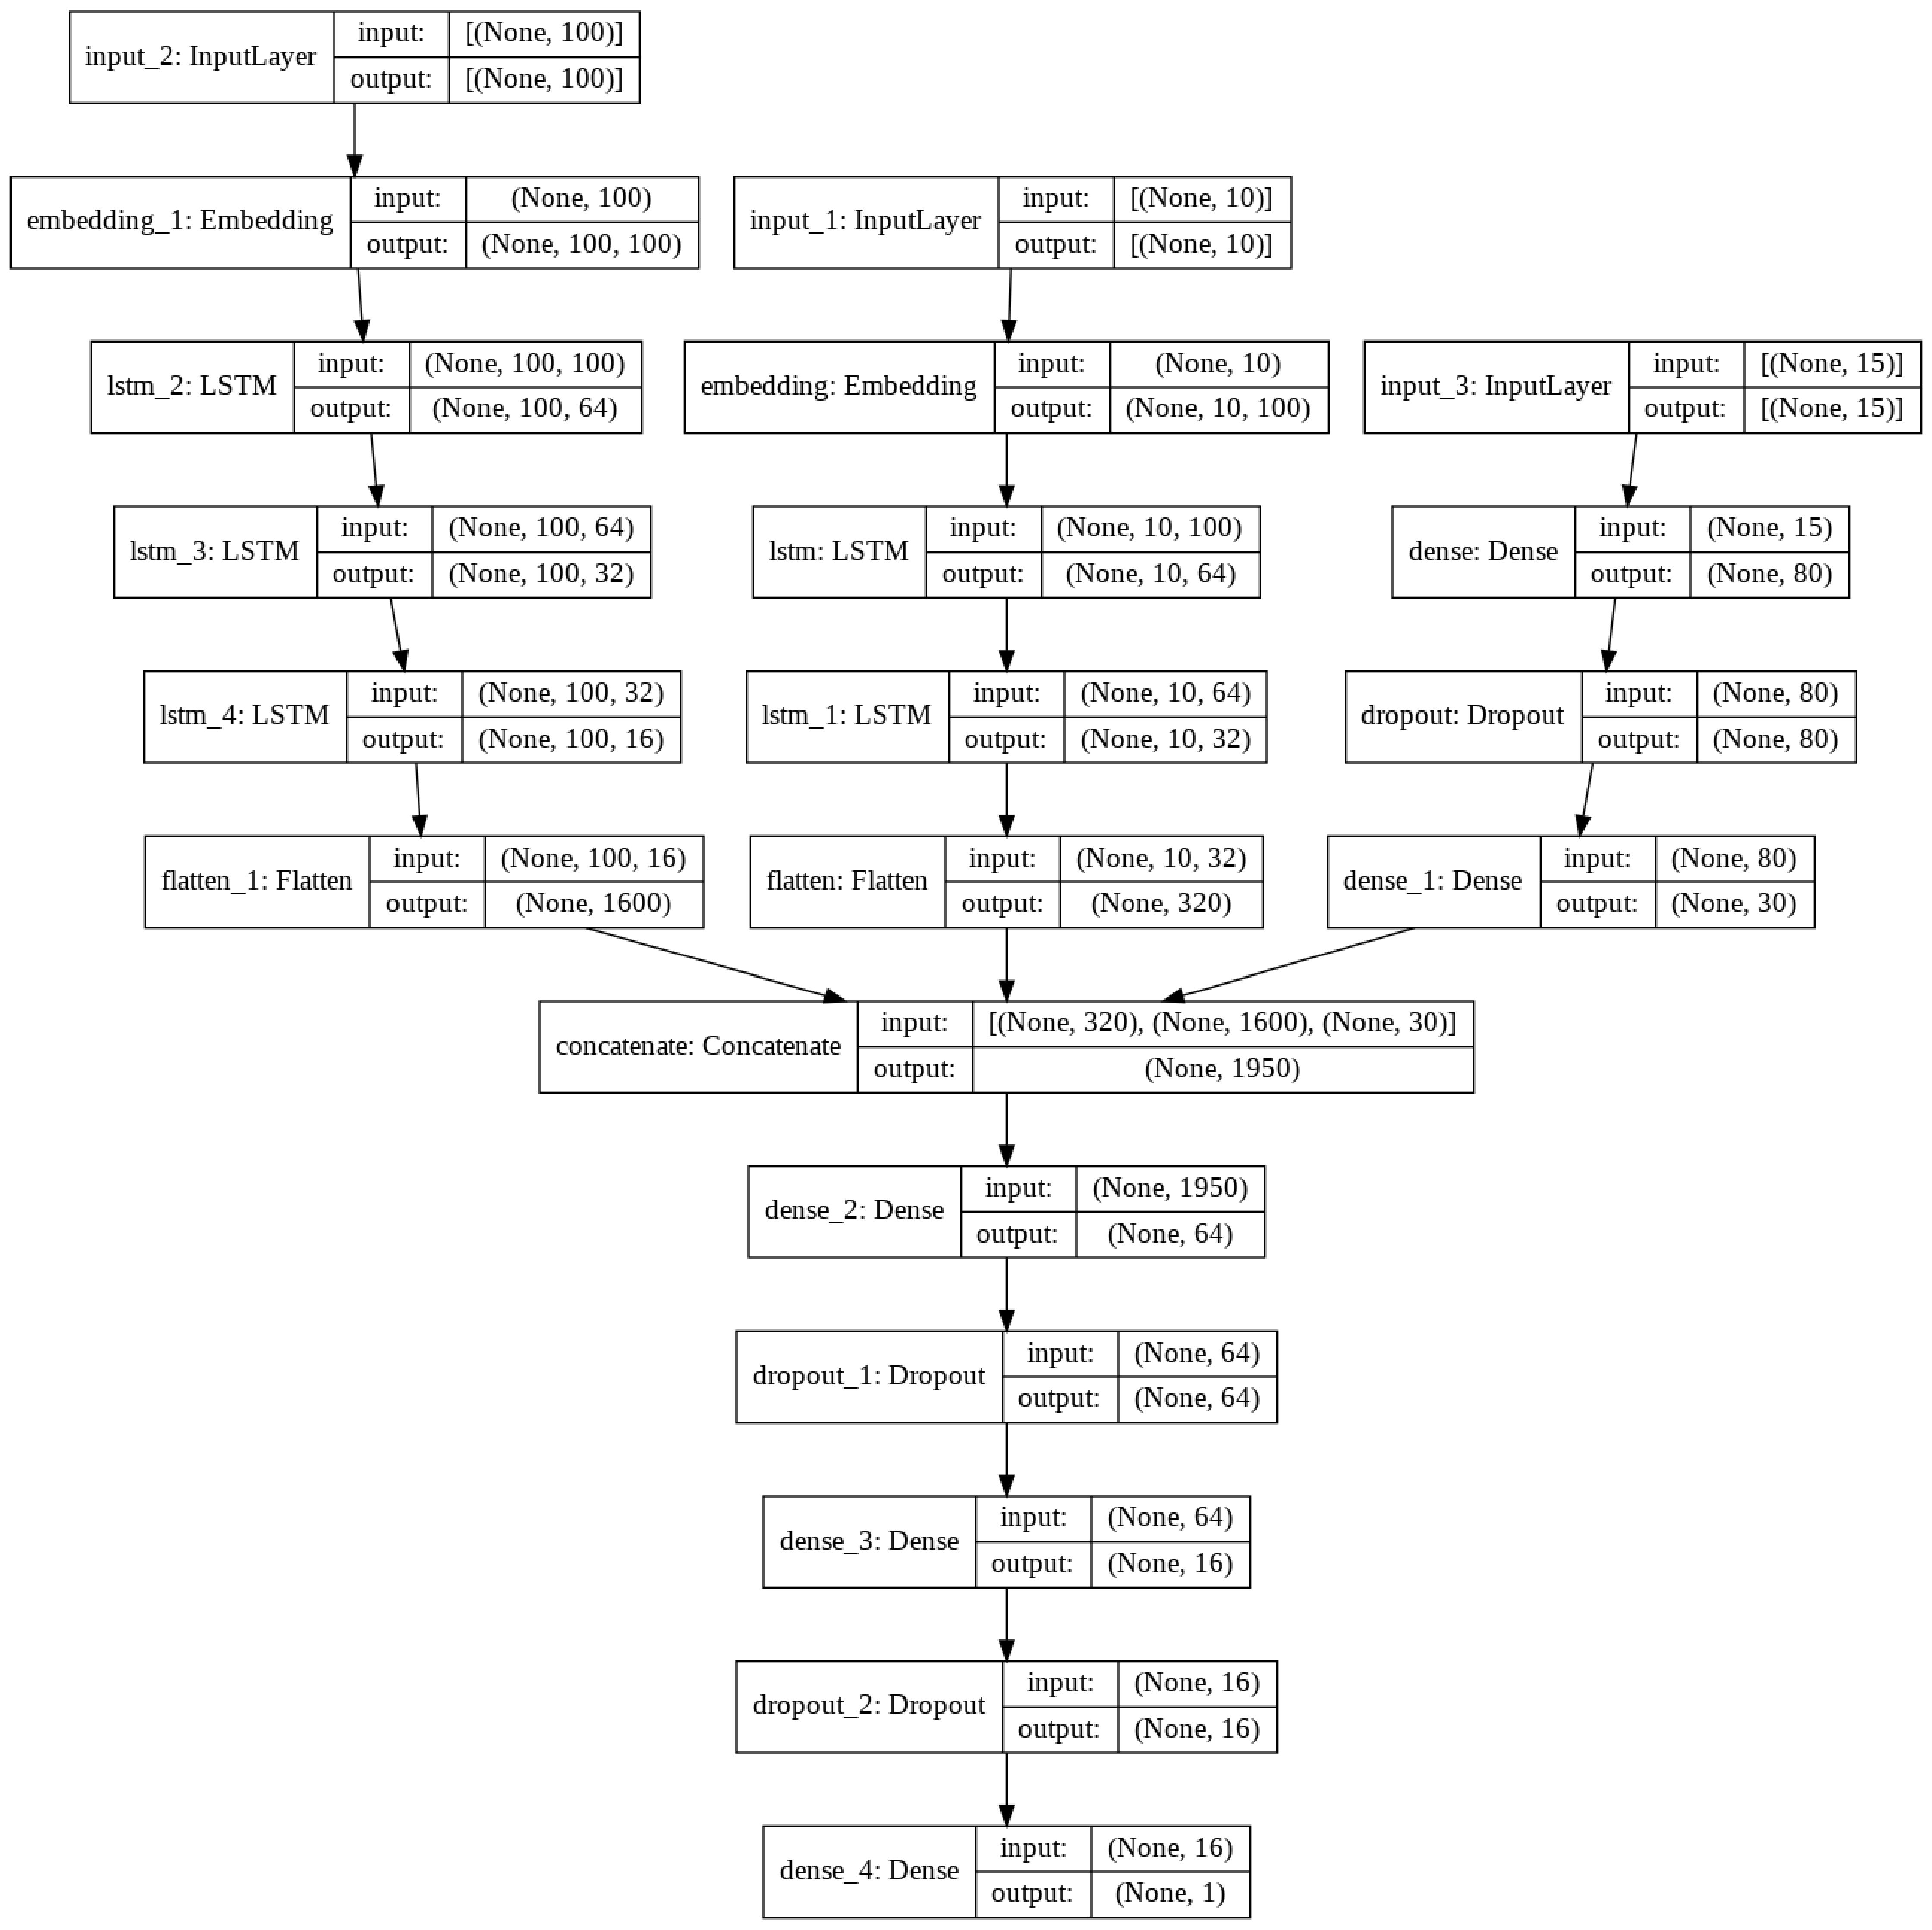

In [73]:
## having some problem with Graphviz, hence plotting the model in google colab and saving it and load it here using matplotlib

im = img.imread('LSTM_Dense_plot.png')
plt.figure(figsize=(80,100));
plt.imshow(im);
plt.axis('off')

In [62]:
from keras import backend

#Defining custom RMSE metric
def rmse(y_true, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

earlystopper = EarlyStopping(monitor='val_loss', min_delta=0.002,  patience=2, mode='auto', verbose=1, restore_best_weights= True)

reducelr = ReduceLROnPlateau(monitor='val_loss', factor= 0.5, patience=1, verbose= 1, min_delta= 0.002)

model1.compile(optimizer= tf.keras.optimizers.Adam(0.0005), loss = 'mean_squared_error', metrics = [rmse])
model1.fit([padded_train_name, padded_train_item, X_train_non_txt.toarray()], y_train, epochs = 20,  validation_data=([padded_test_name, padded_test_item, X_test_non_txt.toarray()],y_test), \
           batch_size=300, shuffle=True, callbacks= [earlystopper, reducelr] )


Epoch 1/20
2422/2422 [==============================] - 1147s 469ms/step - loss: 1.1126 - rmse: 0.7906 - val_loss: 0.4156 - val_rmse: 0.4863
Epoch 2/20
2422/2422 [==============================] - 1184s 489ms/step - loss: 0.4961 - rmse: 0.5436 - val_loss: 0.3156 - val_rmse: 0.4214
Epoch 3/20
2422/2422 [==============================] - 1158s 478ms/step - loss: 0.3609 - rmse: 0.4587 - val_loss: 0.2969 - val_rmse: 0.4090
Epoch 4/20
2422/2422 [==============================] - 1151s 475ms/step - loss: 0.3039 - rmse: 0.4193 - val_loss: 0.2780 - val_rmse: 0.3981
Epoch 5/20
2422/2422 [==============================] - 1148s 474ms/step - loss: 0.2759 - rmse: 0.3990 - val_loss: 0.2666 - val_rmse: 0.3941
Epoch 6/20
2422/2422 [==============================] - 1131s 467ms/step - loss: 0.2629 - rmse: 0.3892 - val_loss: 0.2582 - val_rmse: 0.3848
Epoch 7/20
2422/2422 [==============================] - 1135s 469ms/step - loss: 0.2549 - rmse: 0.3834 - val_loss: 0.2623 - val_rmse: 0.3838

Epoch 00007:

In [63]:
model1.save('Lstm_Dense.h5')

In [65]:
y_train_predict1 = model1.predict([padded_train_name, padded_train_item, X_train_non_txt.toarray()])
y_test_predict1 = model1.predict([padded_test_name, padded_test_item, X_test_non_txt.toarray()])

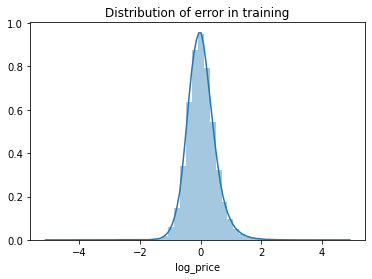

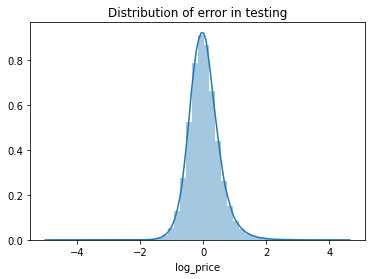

In [67]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure();
sns.distplot(y_train - y_train_predict1.reshape(1,-1)[0]);
plt.title('Distribution of error in training');
plt.show()
    
plt.figure();
sns.distplot(y_test - y_test_predict1.reshape(1,-1)[0]);
plt.title('Distribution of error in testing');
plt.show()

**Getting Train RMSE value 0.3622 and test RMSE value 0.3703**

### Summary

As of now we have used some of machine learning techniques and deel learning techniques, now taking summary of all those models

<table style="width:100%">
  <tr>
    <th>Model</th>
    <th>Train Score</th>
    <th>Test Score</th>
  </tr>
  <tr>
    <td>Lasso_with_Tf-idf</td>
    <td>0.6715</td>
    <td>0.67290</td>
  </tr>
  <tr>
    <td>XGB_with_TF-idf</td>
    <td>0.5007</td>
    <td>0.51510</td>
  </tr>
  <tr>
    <td>LGB_with_Tf-idf</td>
    <td>0.4466</td>
    <td>0.47253</td>
  </tr>
  <tr>
    <td>XGB_with_w2v</td>
    <td>0.5130</td>
    <td>0.53530</td>
  </tr>
  <tr>
    <td>LGB_with_w2v</td>
    <td>0.4959</td>
    <td>0.52700</td>
  </tr>
  <tr>
    <td>CNN1d_LSTM</td>
    <td>0.4188</td>
    <td>0.4213</td>
  </tr>
  <tr>
    <td>LSTM_DENSE</td>
    <td>0.3622</td>
    <td>0.3703</td>
  </tr>
</table>



Now if we comapre all these model, we can conclude that **LSTM with DENSE Layer** works far better than other model. It gives us low Train RMSLE as well as low Test RMSLE